# Applied Deep Learning Tutorial 
contact: Mark.schutera@kit.edu


# Segmentation with U-Net

## Introduction
This tutorial presents a segmentation use-case based on U-Net network (see paper for reference [paper](https://arxiv.org/pdf/1505.04597.pdf)).
First, the theoretical background behind the architecture is discussed. Subsequently you will be guided through the implementation process of the neural network within this Jupyter Notebook. The use-case is based on the initial paper and focuses on cell boundary segmentation, see Fig.1.
<img src="graphics/unet_fig_1.png" width="700"><br>
<center> Figure 1: Right: input image | Left: Prediction of the cell boundaries </center>

## Motivation

While segmentation networks and convolutional neural networks often need a very large amount of training data in order to converge, it is necessary to deploy the training data more efficiently. In segmentation, objects need to be localized and classified. This requires improved semantic understanding. 
The U-Net achieves sample efficiency while capturing both class affiliations and localization performance.  

## U-Net Architecture

<img src="graphics/unet_fig_2.png" width="700"><br>
<center> Figure 2: U-Net architecture </center>

In Fig.2, the architecture of the U-Net is shown. The name is derived from the U-shaped architecture of the downsampling and the upsampling path. The input to the U-Net is an image tile. An image is processed one tile after another. In this manner, the image can be of an arbitrarily large size and for example and its size is not linked to the memory capabilities of your GPU. An example of such a tile can be seen in Fig.3 below.
<img src="graphics/unet_fig_3.png" width="300">


<center> Figure 3: Tile of an image </center>
A tile of an input image is shown. The convolution has no padding, thus the yellow box, the center of the tile, gets a segment prediction output while the blue region is the region which is fed into the neural network. 

The convolutions marked with the blue arrows within Fig.2 process the input by building feature maps of the shown size. These convolution a ReLu function is followed. After the first 3 convolutions a feature map of the size 568x568x64 is received. Thereafter max-pooling operation (2x2 with a stride of 2), marked with red arrows in the image, downsample the image size but simultaneously doubles the size of the feature map.<br>
This is repeated until we get a single vector with a high resolution feature map. Thus this contracting path reduces the information of the location by simultaneously increase the context information (features). From this high resolution feature vector, now a high resolution segmentation-map with a high accuracy of the location is built. This is done by expand the vector with up-sampling, due up-convolution and with, and this is the novelty, concatenate the high resolution feature map from the contracting path. This is shown with the grey arrows seen in the Fig.2. Furthermore after every upconcolution a ReLU operation is appended. 
With this combination of knotting the upconcolution of the high resolution feature map with the localization information, it is not getting loss as it is the case with just do an "autoencoding". <br>
Due to the aforementioned loss of information with the nonpadded convolution, the feature map needs to be cropped.
The final layer consists out of a 1x1 convolution which maps each 64 component feature vector to the desired number of classes. And thus devide the image into the requested segments. 

## Implementing the code 

We will orientate with this tutorial on the implemtation of the code from [this](https://github.com/zhixuhao/unet) github repository.
Due to the implementation in Jupyter Notebook we will write the whole code in one template. Instead of different python documents we will use classes.
The original repository consists out of three python documents. To work only with this notebooky every function is integrated here, thus you don't have to switch documents or import other python-files.


In [0]:
# If you do not have the data yet, you can download it here:
# https://github.com/zhixuhao/unet/tree/master/data/membrane
# Now go to the folder in which this jupyter Notebook ist located and running
# and copy the <<data>> folder there and renaming either the folders according 
# to the Path written below or change the path written below according to
# your folder-names

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#!unzip -uq "/content/drive/My Drive/Colab Notebooks/unet-master.zip" -d "/content/drive/My Drive/Colab Notebooks/unet-master"

When you run the Code below and you set the Path accordingly, an image and its label should be shown.

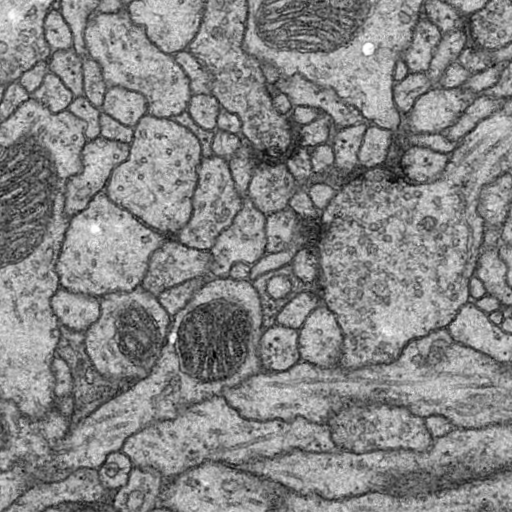

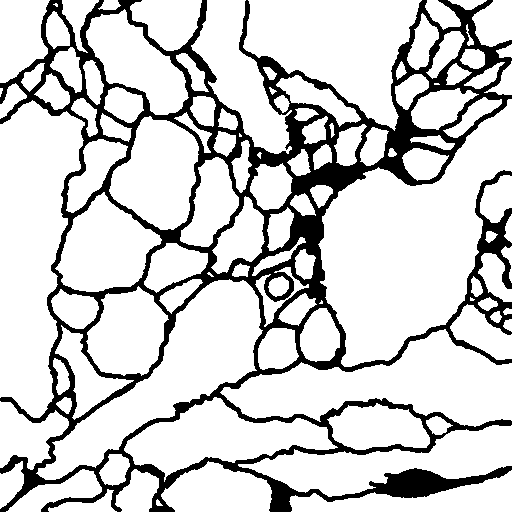

In [23]:
##########################################################
#           In this box some code must be added          #
##########################################################
from IPython.display import Image
#We want to see one of the training data with its label
# Change the folders or the code that the path points to your data
training_images = '/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/train/image/'
training_labels = '/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/train/label/'

#We use the function Image(file_name) to print the image '0.png' and the label 'o.png'
display(Image(training_images + '14.png'))
display(Image(training_labels + '14.png'))


### Buidling the Unet Architecture

In the next box all libraries and packages we will need for the U-Net and its data prepration will be imported. 
Because Keras is a part of tensorflow and is installed within, it comes preinstalled with tensorflow <br>
"tensorflow.keras"

If something went wrong with importing the packages, you can try to restart your kernel.

In [0]:
from __future__ import print_function
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os 
import glob
import skimage.io as io #pip install scikit-image pip install scipy within your conda environment
# if This Error occurs:
# <<ImportError: cannot import name 'rgb2gray'>>
# restart your kernel
import skimage.transform as trans
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

To build the archtecture which is shown in fig.1 keras is a very intuitive and simply way to do so. We will slithly adapt the archtecture from the original one like seen in fig.3. To build this neural net we do need the following functions:
- 2D Convolution
- MaxPooling 
- Concatenation

We will add an Dropout after convolution 4 and 5,  please explain what could be the purpose to add those two layers?





In [0]:
# Training a large network with few images quickly leads to overfitting.  
# Regularization should protect the network from overfitting and improve generalization


Let's start coding the Network with the following functions:

- Conv2D(filters/feature maps, kernel size, activation, padding, kernel_initializer)(input Data)
- MaxPooling2D(pool_size = (x,x))(input Data)
- Dropout(dropout rate)(input Data)
- concatenate([input Data 1, Input Data 2], axis= x)
- Conv2D()(UpSampling2D(size=(x,x))(Input Data)

As activation function we take 'relu' (Rectified Linear Unit).
As padding we chose 'same', thus despite convolution we get an output of the same size as the input.
The kernel initializer defines how we want to set the initial weights of this Keras layer. For example:
- Zeros: initialize with a tensor of zeros
- Ones: initialize with a tensor of ones
- RandomNormal: initialize the tensor with a normal distribution
- TruncatedNormal: initialize the tensor with a truncated normal distribution, where all values more than two standard deviations from its mean are neglected
- he_normal: a zero mean Gaussian distribution with a standard deviation of \sqrt{(2/n)}, where n is the number of inputs/connections of our weight tensor <br>

Which initialization do you think is beneficial?


## **Answer**: 
For the initialization of the weight I would use the Gaussian distribution (he_normal). This contains the dependence of the initial weights values on the number of inputs/connections and can therefore initialize the initial weights more efficiently



When the architecture is configured correctly we have to define the inputs and outputs of our Neural Network with the method: <br> Model(inputs= ___ , outputs= __).
Thereafter we need to compile the whole architecture for training. Therefore we need to define the optimizer, the learning rate, the loss function and we can determine on which metrics we want to evaluate our model. 

List 3 loss functions and 3 optimizers and explain them:


### Optimizer:

**- Stochastic gradient descent**: slow optimization "to the optimal value".

**- AdaGrad**: Individually adapts the learning rates of all model parameters, inversely proportional to the historical values of the gradient.

**- RMSProp**: Modifies AdaGrad by approaching the accumulation of historical gradient values as a exponentially weighted moving average. Influence of very old historical values is reduced. (Fast optimization "in the right direction".) 

**- Adam(Adaptive moments)**: combination of exponential weight decay together with first- andsecond-order moments.(Fast optimization "in the right direction".)

### Loss Funktion:

**- Mean Squared Error**: Continuous improvement through training → . Gradient becomes smaller and smaller → network learns slower (when using Softmax)

**- Cross-entropy** (Binary, Categorical or Sparse Categorical): Heavily penalizes opposing predictions and gives rise to the problem of imbalanced

**- Dice-coefficient**: is a statistic used to gauge the similarity of two samples. Similar to the IoU (Intersection over union). More robust with respect to imbalanced classes

Choose one of these optimizers you thing fit best for your U-Net and experiment with the learning rate.
The return of our function should be the model.


## The Dice Coefficient Loss

In this section we will implement the Dice Coefficient loss, so we can use it with our own model.
The Dice Coefficient, also known as Sørensen–Dice coefficient compares the similarity of two quantities. When working with neural network we want to compare the prediction of our network and the ground truth. The dice coefficient can be interpreted as Intersection over union, this makes it intuitive to interpret and a direct loss function for segmentation errors.
<br>
The equation of the dice loss is given with:
\begin{align}
    DSC = \frac{2*|X \cap Y|}{|X|+|Y|}
\end{align}

Before coding this equation you may think about:
   - do I need the absolute values?
   - how can i easily calculate the intersection, assuming that the ground truth is a one-hot vector:
    \begin{align}
        y_{true} = \begin{bmatrix}
        0.0 &  0.0 &  0.0 &  1.0
        \end{bmatrix}
    \end{align}
    \begin{align}
        y_{pred} = \begin{bmatrix}
        0.1 &  0.2 &  0.0 &  0.7
        \end{bmatrix}
    \end{align}
<br>

Now start with the coding, following these steps: 
- First we want to flatten our input to the loss y_true and y_pred
- Calculate the counter with its intersection
- Calulate the denominator, (you may want to add a small epsilon to it)
- Obtain the coefficient

Because we work here with the backend of keras, we need to do our calculations with K.operation.
K is the backend we imported above with "from tensorflow.keras import backend as K".
Here a list of some operations is listed, if you need more, just google them:
- sum: K.sum()
- flatten: K.flatten()
- mean: K.mean()
- reshape: K.reshape()
- dot: K.dot()
- epsilon: K.epsilon()

In [0]:
def dice_coef(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    numerator = (2. * intersection + K.epsilon())
    denominator = (K.sum(y_true_flatten) + K.sum(y_pred_flatten) + K.epsilon())
    coef = numerator / denominator
    return coef

Why it is advised to add an epsilon to your denominator?


## Answer: 
We need a smoothing factor for numeric stability

In [0]:

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [0]:
##########################################################
#           In this box some code must be added          #
##########################################################

def unet(pretrained_weights=None, input_size=(256, 256, 1)): #the values given for the parameters are the default values
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    # complete the missing layers (your may use copy and past plus adapting)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    # In the last layer we chose the <sigmoid> as activation function because the output has to be between zero and one.
    # We normalized out pixle values by deviding through 255.
    # For our example we have only one class and thus only needing
    # zero being white (our predicted object-segment) and 1 beeing black. 
    # but if we have more that one class the different colors will also lie inbetween 0 and 1 and every
    # prediction is labeld with the appropriate number. 
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    # With the following method <Model> we define out input and output of or Neural Network
    # please complete:
    model = Model(inputs=inputs, outputs=conv10)

    # with Model.compile we configure and prepare our netwrok for training. Thus we define our optimizer for 
    # learning with it's learning rate, the loss function and the metrics.
    # model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    # model.compile(optimizer=SGD(lr=1e-4), loss=dice_coef_loss, metrics=['accuracy'])
    # model.compile(optimizer=SGD(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=['accuracy'])
    # model.summary()
    
    # this part we need for resume to a training or printing test, results for an already trained network, be careful
    # that the input_size you defined for the model match with the one you defined for the model you take the pretrained
    # weights from!
    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

### Preparing the Data

So far we build the architecture of our neural net and the data, consists out of images and labels. To train the neural network in the next step the data has to be prepared.

First of all we define a color map for our labels. With this map we define a specific mask-color for each of the appearing objects. 
Because we only have one ground truth label, the boundaries of the cell, we do not really need a color map. But as you can use this code for other task and to familiar with such a Color dicitonary some COLOR_DICT is given below.

In [0]:
# this part below assign the labeling color for the predictions to the labels
# for our purpose it is not really important because we only have "unlabelled" labels, but if you want to experiment
# with other data you might can use and easily adapt this
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

COLOR_DICT = np.array([Sky, Building, Pole, Road, Pavement, Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

#### Adjusting the Data

Before we feed the data to our neural network, it has to be adjusted properly. 
The first step always helps is to normalize our input data. Important is to normalize both the labels and the images, so that the neural network does not learn something wrong, warped or even nothing at all.
As said befor this code can also used to implement multiple classes, and therefore needs a flag whether the input is multi class (flag_multi_class = True) or just binary. 
In this tutorial we got the binary case and therefor the images and masks just need to be normalized.
This is done by dividing through 255. 
To get the mask as one-hot vector, we need to convert it. Every mask value > 0.5 should be 1 and every mask value <= 0.5 should be 0. This has to be done below.

In [0]:
##########################################################
#           In this box some code must be added          #
##########################################################
def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            #for one pixel in the image, find the class in mask and convert it into one-hot vector
            #index = np.where(mask == i)
            #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
            #new_mask[index_mask] = 1
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        # normalize the image
        img = img / 255
        # normalize the mask 
        mask = mask /255
        # convert your mask vector into a one-hot vector 
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)

#### The training Generator

The next function will be the "trainGenerator".
Because deep learning tasks only get to learn something if they are trained with a lot of data, we have to provide it. But with the data we downloaded, there are only 30 images in the folder train/. For a deep learning task that is way too little. Therefore we will generate our own data with data augmentation. This function will do the data augmentation on the given images with functions like rotation, shear and zoom etc. It is important that the ground truth and input images are transformed together with the same transformation functions.

How far we can get with augmentation depends on the data and task at hand. But for the given task data augmentation really does its part.
This is also due to cropping multiple times from a single image, which supports with multiple object instances in a single sample.

To save the data augmentation results, if you want to look at them you can set the save_to_dir to the path where you want to save them.
The utilized data augmentation approach is the ImageDataGenertor pipeline provided within Keras. This function takes a dictionary of arguments to augmentate your data. The documentations for more information can be found here 
https://keras.io/preprocessing/image/.

Why is it important to set the same seed for the mask and the image and what does seed stand for?


### Answer 
seed-Parameter is random seed for applying random image augmentation and shuffling the order of the image. We need the same augmentation and shuffling for image and mask

In [0]:
##########################################################
#           In this box some code must be added          #
##########################################################
#change save_to_dir to your output path if you do not want to save the output of the trainings Generator the path
# is "None"
def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None, target_size = (256,256),seed = 1):
    '''
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    # the generated masks and images are now passed on the function <<adjustData>> discussed beforehand
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)
        
# to understand what yield is: https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do

#### The Testing Generator

The testGenerator function will generate your test data on the images provided within the test folder. 
It will first read the images from the test-folder as gray images normalize them and resize them like defined in with the parameter target_size. Depending on the amount of object-classes you need the image vector will be extended. For our purpose again it is not necessary.  

In [0]:
def testGenerator(test_path,num_image = 30,target_size = (256,256),flag_multi_class = False,as_gray = True):
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,"%d.png"%i),as_gray = as_gray)
        img = img / 255
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        yield img

#### The visualizer of the labels and predictions

In [0]:
def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255

#### Saving the results

In [0]:
def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

## Run the training

Now all functions we need to run our Unet are defined and thus we can start the training.

First we need to augmentate our dataset which contains up to now only 30 images.
Therefor we can define some parameters within out data augmentation dictionary "data_gen_args" for this augmentation. To get some results and not just a gray image as prediciton, you should start with small parameters here.

Then we will generate the data with the beforehand defined parameters and the images given in the training folder. 
The first number hereby defines the batch_size, which you can change to a bigger number if your Computer fill in the requirements (GPU, Memory).

Now it is time to built our UNet with just calling the function and than start the traing.
You can change the "steps_per_epoch" and "epochs". The more you chose the better the results will get but also the longer the training will take.
The Checkpoint-file will be saved within your Jupter Notebook folder.

In [16]:
##########################################################
#           In this box some code must be added          #
##########################################################
# if it fails to run the training on your tensorflow-gpu 
# rerun it on a tensorflow cpu version

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,'/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/train','image','label',data_gen_args,save_to_dir = None)

epochs=10

model = unet()
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/train/unet_Adam_dice_coef_loss_10.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=300,epochs=epochs,callbacks=[model_checkpoint])


Instructions for updating:
Please use Model.fit, which supports generators.
Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Epoch 1/10
300/300 [==============================] - ETA: 0s - loss: 0.3888 - accuracy: 0.7770
Epoch 00001: loss improved from inf to 0.38876, saving model to /content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/train/unet_Adam_dice_coef_loss_10.hdf5
300/300 [==============================] - 114s 380ms/step - loss: 0.3888 - accuracy: 0.7770
Epoch 2/10
300/300 [==============================] - ETA: 0s - loss: 0.3821 - accuracy: 0.7813
Epoch 00002: loss improved from 0.38876 to 0.38205, saving model to /content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/train/unet_Adam_dice_coef_loss_10.hdf5
300/300 [==============================] - 115s 384ms/step - loss: 0.3821 - accuracy: 0.7813
Epoch 3/10
300/300 [==============================] - ETA: 0s - loss: 0.3766 - accuracy: 0.7817
Epoc

## Test your Model

When the training is done you can generate some prediction on your test data and save them within the test-image folder.

In [17]:
test_images_path = "/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/"
#test_images_result_path = "/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/dice_coef_loss/sgd_result_5/"
#test_images_result_path = "/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/dice_coef_loss/sgd_result_10/"
#test_images_result_path = "/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/cross_entropy/adam_result_5/"
#test_images_result_path = "/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/cross_entropy/adam_result_10/"
#test_images_result_path = "/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/cross_entropy/sgd_result_5/"
#test_images_result_path = "/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/cross_entropy/sgd_result_10/"
#test_images_result_path = "/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/dice_coef_loss/adam_result_5/"
test_images_result_path = "/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/dice_coef_loss/adam_result_10/"

testGene = testGenerator(test_images_path)
results = model.predict_generator(testGene,30,verbose=1)
saveResult(test_images_result_path,results)

Instructions for updating:
Please use Model.predict, which supports generators.
30/30 [==============================] - 2s 78ms/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: /content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/dice_coef_loss/adam_result_10/0_predict.png is a low contrast image
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: /content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/dice_coef_loss/adam_result_10/1_predict.png is a low contrast image
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: /content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/dice_coef_loss/adam_result_10/2_predict.png is a low contrast image
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: /content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/dice_coef_loss/adam_result_10/3_pred

### Show the results

We can now either look in the folder how well our network was trained or just show some images and their predicitons here:
If your prediction is just a gray image, your model wasn't trained good enough, and you might want to change some parameters (first of all steps_per_epoch and epochs)

Here you can load a pretrained net and test your data on it:

In [18]:
test_images_path = "/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/"
#test_with_pretrained_weights_result_path = "/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/dice_coef_loss/sgd_with_pretrained_weights_5/"
#test_with_pretrained_weights_result_path = "/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/dice_coef_loss/sgd_with_pretrained_weights_10/"
#test_with_pretrained_weights_result_path = "/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/cross_entropy/adam_with_pretrained_weights_5/"
#test_with_pretrained_weights_result_path = "/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/cross_entropy/adam_with_pretrained_weights_10/"
#test_with_pretrained_weights_result_path = "/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/cross_entropy/sgd_with_pretrained_weights_5/"
#test_with_pretrained_weights_result_path = "/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/cross_entropy/sgd_with_pretrained_weights_10/"
#test_with_pretrained_weights_result_path = "/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/dice_coef_loss/adam_with_pretrained_weights_5/"
test_with_pretrained_weights_result_path = "/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/dice_coef_loss/adam_with_pretrained_weights_10/"

# load the pretrained net within the folder
model = unet(pretrained_weights='/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/train/unet_Adam_dice_coef_loss_10.hdf5')

testGene = testGenerator(test_images_path)
results = model.predict_generator(testGene,30,verbose=1)
saveResult(test_with_pretrained_weights_result_path, results)

30/30 [==============================] - 2s 74ms/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: /content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/dice_coef_loss/adam_with_pretrained_weights_10/0_predict.png is a low contrast image
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: /content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/dice_coef_loss/adam_with_pretrained_weights_10/1_predict.png is a low contrast image
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: /content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/dice_coef_loss/adam_with_pretrained_weights_10/2_predict.png is a low contrast image
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: /content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data

In [0]:
import matplotlib.pyplot as plt
import cv2


def plot_images_with_labels(
    images: list, labels: list
) -> None:
    if len(images) != 9:
        images = images[:9]
        labels = labels[:9]

    plt.figure(figsize=(12, 10))
    index = 0
    for image_file, label in zip(images, labels):
        index += 1
        plt.subplot(3, 3, index)
        img=cv2.imread(image_file)
        #rgb_img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #rgb_img=cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        rgb_img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_img)
        plt.title(label)
        plt.axis("off")



RESULT OF TRAINING


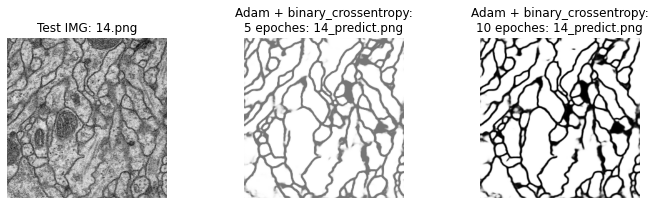

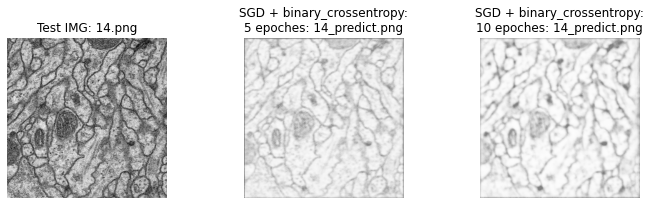

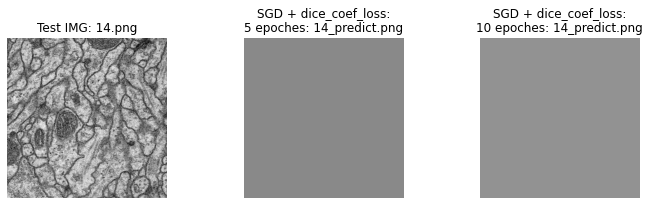

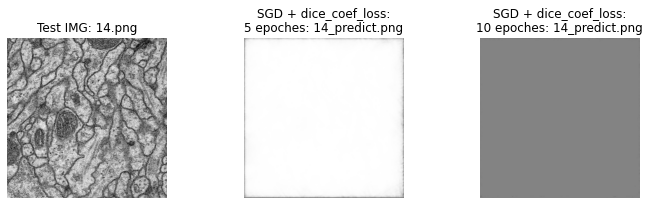

In [22]:
# show results with this weights
test_path = "/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/"
dice_result_path_10 = "/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/dice_coef_loss/sgd_result_10/"
dice_result_path_5 = "/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/dice_coef_loss/sgd_result_5/"
entr_result_path_10 = "/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/cross_entropy/adam_result_10/"
entr_result_path_5 = "/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/cross_entropy/adam_result_5/"
sgd_entr_result_path_10 = "/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/cross_entropy/sgd_result_10/"
sgd_entr_result_path_5 = "/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/cross_entropy/sgd_result_5/"
adam_dice_result_path_10 = "/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/dice_coef_loss/adam_result_10/"
adam_dice_result_path_5 = "/content/drive/My Drive/Colab Notebooks/unet-master/unet-master/data/membrane/test/dice_coef_loss/adam_result_5/"
# number 0 to 29 your want to show
img_number = 14

print("RESULT OF TRAINING")

lab_list = ['Test IMG: '+ str(img_number)  + '.png', 'Adam + binary_crossentropy:\n5 epoches: '+ str(img_number)  + '_predict.png', 'Adam + binary_crossentropy:\n10 epoches: '+ str(img_number)  + '_predict.png']
img_list = [test_path + str(img_number)  + '.png', entr_result_path_5 + str(img_number)  + '_predict.png', entr_result_path_10 + str(img_number)  + '_predict.png']
plot_images_with_labels(img_list, lab_list)

lab_list = ['Test IMG: '+ str(img_number)  + '.png', 'SGD + binary_crossentropy:\n5 epoches: '+ str(img_number)  + '_predict.png', 'SGD + binary_crossentropy:\n10 epoches: '+ str(img_number)  + '_predict.png']
img_list = [test_path + str(img_number)  + '.png', sgd_entr_result_path_5 + str(img_number)  + '_predict.png', sgd_entr_result_path_10 + str(img_number)  + '_predict.png']
plot_images_with_labels(img_list, lab_list)

lab_list = ['Test IMG: '+ str(img_number)  + '.png', 'SGD + dice_coef_loss:\n5 epoches: '+ str(img_number)  + '_predict.png', 'SGD + dice_coef_loss:\n10 epoches: '+ str(img_number)  + '_predict.png']
img_list = [test_path + str(img_number)  + '.png', adam_dice_result_path_5 + str(img_number)  + '_predict.png', adam_dice_result_path_10 + str(img_number)  + '_predict.png']
plot_images_with_labels(img_list, lab_list)

lab_list = ['Test IMG: '+ str(img_number)  + '.png', 'SGD + dice_coef_loss:\n5 epoches: '+ str(img_number)  + '_predict.png', 'SGD + dice_coef_loss:\n10 epoches: '+ str(img_number)  + '_predict.png']
img_list = [test_path + str(img_number)  + '.png', dice_result_path_5 + str(img_number)  + '_predict.png', dice_result_path_10 + str(img_number)  + '_predict.png']
plot_images_with_labels(img_list, lab_list)


## Results

The combination of the adam-optimizer and the binary_crossentropy have the results closest to the training labels. 
The combination of the SGD-optimizer and the binary_crossentropy produce images with structures closest to the original image.
The results of dice-coeffizient loss are unfortunately not satisfactory. Maybe I made an error while programming the coefficient

Furthermore it was a lot of fun to build a complex model with convolutional AND deconvolutional part by skipping connections between these parts, train them and test them on the test data. 


